<a href="https://colab.research.google.com/github/g-tumwesigye/FitPredictor_Model/blob/main/FitPredictor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FITPREDICTOR NEURAL NETWORK DIAGRAM**

Saving FitPredictor_Neural_Network_diagram.png to FitPredictor_Neural_Network_diagram.png


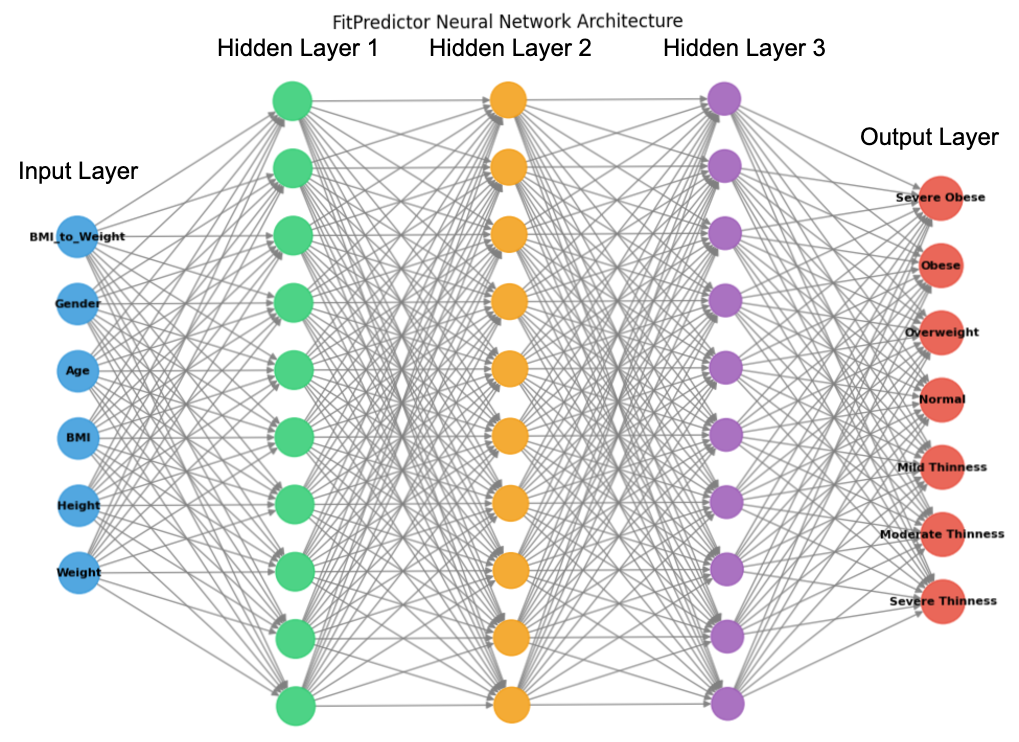

In [1]:
from google.colab import files

# Uploading the diagram
uploaded = files.upload()

from IPython.display import display, Image

# Displaying the diagram
display(Image("FitPredictor_Neural_Network_diagram.png"))



**IMPORTING LIBRARIES**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import os
import joblib
from tensorflow.keras.models import load_model
print("All the required libraries have been imported!")

All the required libraries have been imported!


**DATASET LOADING**

In [3]:
data = pd.read_csv("/content/fitpredictor_dataset.csv")

# Displaying the first few rows
print("First 5 rows of the dataset:")
display(data.head())

# Show the number of rows & columns
print(f"\n Dataset shape: {data.shape}")


First 5 rows of the dataset:


,Weight,Height,BMI,Body Fat Percentage,BFPcase,Gender,Age,BMIcase,Exercise Recommendation Plan
0,76.811975,1.820521,23.175956,18.281148,Acceptable,Male,29,normal,4
1,77.721154,1.945498,20.534184,13.731021,Fitness,Male,23,normal,4
2,87.558726,1.742754,28.828859,42.304631,Obese,Female,57,over weight,5
3,89.473356,1.758318,28.940017,27.958021,Obese,Male,41,over weight,5
4,69.963943,1.722570,23.578732,16.464478,Fitness,Male,19,normal,4



 Dataset shape: (5000, 9)


**DATA PREPROCESSING & VISUALIZATION**


 Checking for missing values:
Weight                          0
Height                          0
BMI                             0
Body Fat Percentage             0
BFPcase                         0
Gender                          0
Age                             0
BMIcase                         0
Exercise Recommendation Plan    0
dtype: int64

 THE HEATMAP:


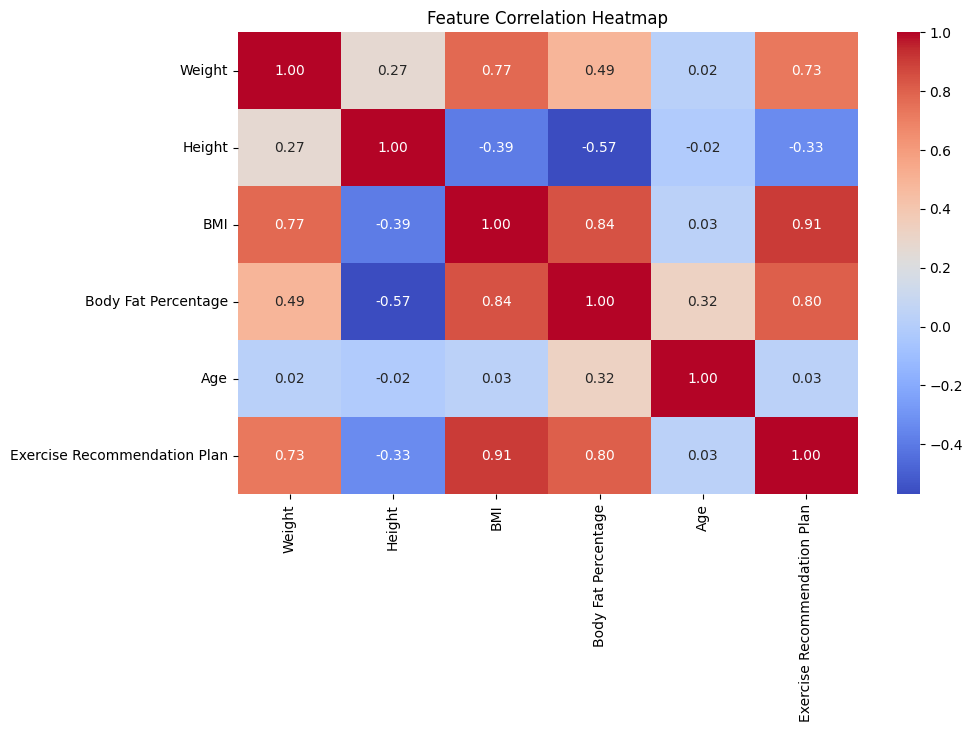

In [4]:
# Checking for missing values
print("\n Checking for missing values:")
print(data.isnull().sum())


# Heatmap
print("\n THE HEATMAP:")
plt.figure(figsize=(10,6))
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


**FEATURE ENGINEERING**

In [5]:
# Drop highly correlated features
data.drop(columns=["Body Fat Percentage", "BFPcase", "Exercise Recommendation Plan"], inplace=True)

# Creating a new feature
data["BMI_to_Weight"] = data["BMI"] / data["Weight"]


# Standardizing numerical features
scaler = StandardScaler()
numerical_features = ["Weight", "Height", "BMI", "Age", "BMI_to_Weight"]
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Encoding categorical features
label_encoders = {}
categorical_features = ["Gender", "BMIcase"]
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

# Splittig data into train (70%), validation (15%) & test (15%)
X = data.drop(columns=["BMIcase"])
y = data["BMIcase"]
y = tf.keras.utils.to_categorical(y)

#spliting train (70%) & temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
X, y, test_size=0.3, stratify=y.argmax(axis=1), random_state=42
)

# splitting temp (30%) into validation (15%) & test (15%)
X_val, X_test, y_val, y_test = train_test_split(
X_temp, y_temp, test_size=0.5, stratify=y_temp.argmax(axis=1), random_state=42
)

# Handling class imbalance with SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.argmax(axis=1))
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled)

**FUNCTION FOR MODEL TRAINING, SAVING, PREDICTING & COMPUTING THE EVALUATION METRICS**

In [6]:
def train_save_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, save_dir="/content/saved_models", callbacks=None):
    os.makedirs(save_dir, exist_ok=True)

    # Passing the callbacks parameter
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    model.save(os.path.join(save_dir, f"{model_name}.h5"))

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f"\n{model_name} Results:")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")

    return history, y_pred_probs, y_pred_classes, y_true


**THE SIMPLE NEURAL NETWORK WITH NO OPTIMIZER**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3867 - loss: 1.4464 - val_accuracy: 0.7400 - val_loss: 0.7396
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6125 - loss: 0.8968 - val_accuracy: 0.7840 - val_loss: 0.5665
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6729 - loss: 0.7506 - val_accuracy: 0.8187 - val_loss: 0.4749
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7061 - loss: 0.6658 - val_accuracy: 0.8280 - val_loss: 0.4333
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7428 - loss: 0.5981 - val_accuracy: 0.8107 - val_loss: 0.4415
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7653 - loss: 0.5486 - val_accuracy: 0.8240 - val_loss: 0.4010
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7934 - loss: 0.4972 - val_accuracy: 0.8387 - val_loss: 0.3652
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8005 - loss: 0.4761 - val_accu

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

simple_nn_model Results:
 Accuracy: 0.8653
 Precision: 0.8644
 Recall: 0.8653
 F1 Score: 0.8646


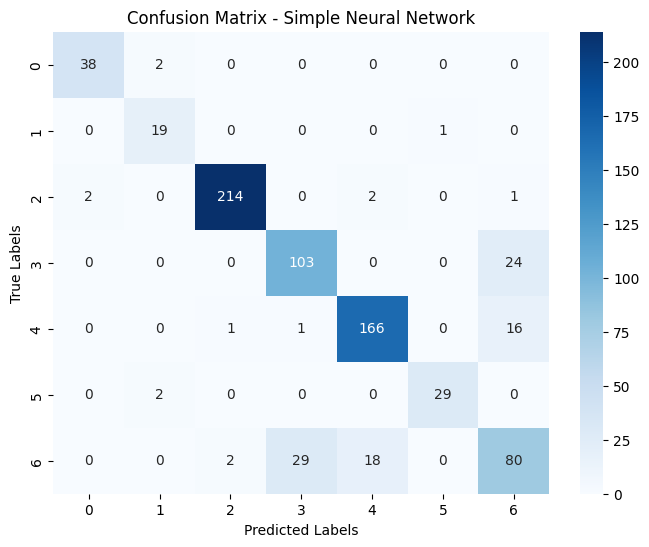

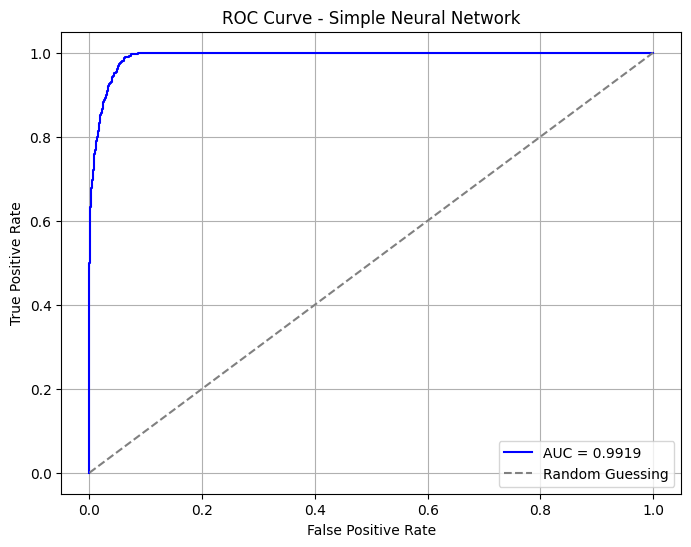

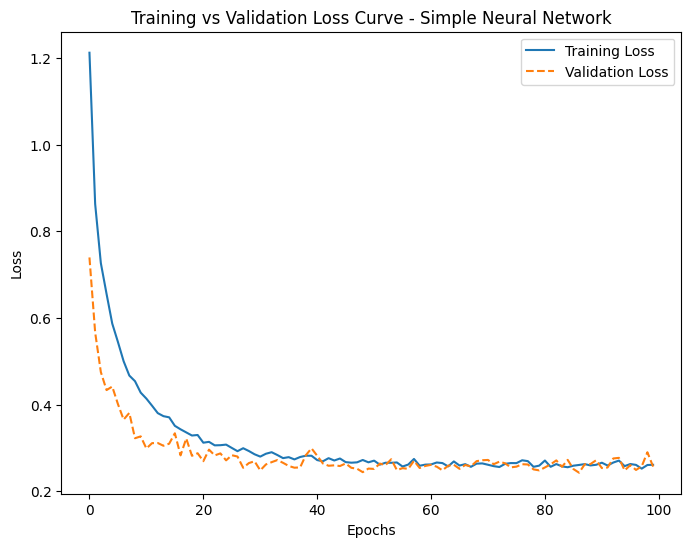

In [7]:
# Defining the Simple Neural Network
simple_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compiling the model
simple_nn.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Training, saving, predicting and evaluating the model
history, y_pred_probs, y_pred_classes, y_true = train_save_evaluate(
    simple_nn, "simple_nn_model",
    X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test
)

# Computing ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
auc_score = auc(fpr, tpr)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Simple Neural Network")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Simple Neural Network")
plt.legend()
plt.grid(True)
plt.show()

# Training vs Validation Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve - Simple Neural Network")
plt.legend()
plt.show()

**THE LOGISTIC REGRESSION MODEL**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



 Logistic Regression Results:
 Accuracy: 0.8240
 Precision: 0.8363
 Recall: 0.8240
 F1 Score: 0.8273
 AUC Score: 0.9820


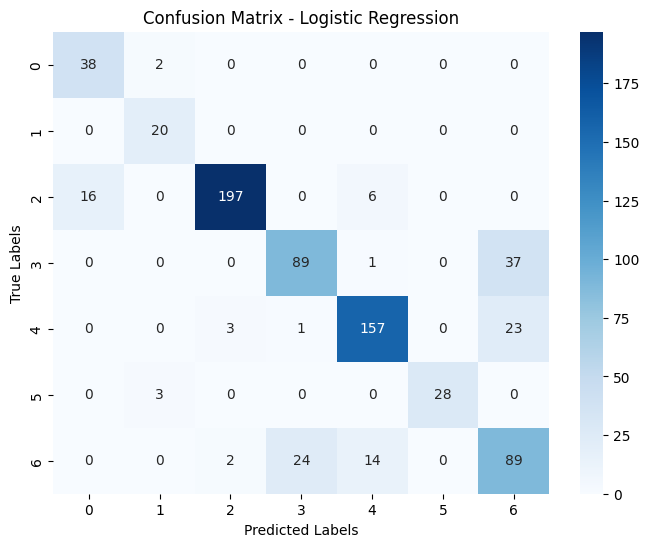

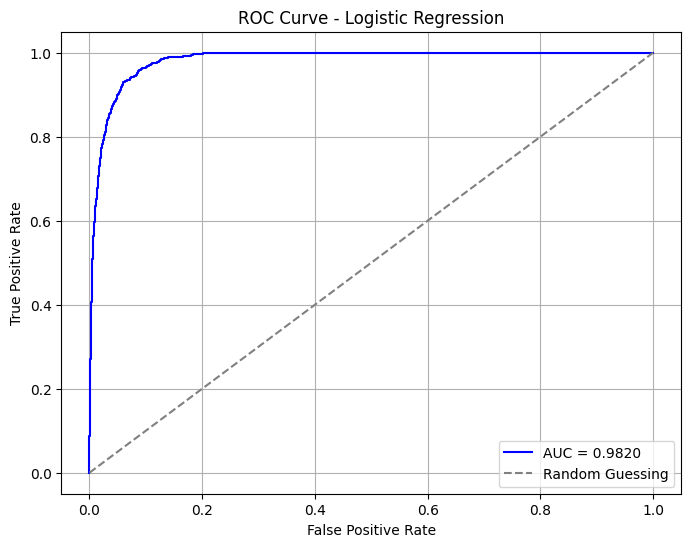


 Total misclassified samples: 132

 Misclassified Samples:
  - Sample 1: True Label = 6, Predicted = 3
  - Sample 7: True Label = 0, Predicted = 1
  - Sample 15: True Label = 4, Predicted = 6
  - Sample 18: True Label = 6, Predicted = 4
  - Sample 30: True Label = 3, Predicted = 6


In [8]:
# Defining and training the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')

# Fit the model
log_reg.fit(X_train_resampled, np.argmax(y_train_resampled, axis=1))

# Saving the Model
saved_models_dir = "/content/saved_models"
os.makedirs(saved_models_dir, exist_ok=True)
joblib.dump(log_reg, os.path.join(saved_models_dir, "logistic_regression_model.pkl"))

# Predicting on test set
y_pred_probs = log_reg.predict_proba(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Computing evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Computing ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
auc_score = auc(fpr, tpr)

# Printing results
print(f"\n Logistic Regression Results:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc_score:.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis - Misclassified Samples
misclassified = (y_true != y_pred_classes).sum()
print(f"\n Total misclassified samples: {misclassified}")

error_indices = np.where(y_true != y_pred_classes)[0]
print("\n Misclassified Samples:")
for i in error_indices[:5]:
    print(f"  - Sample {i}: True Label = {y_true[i]}, Predicted = {y_pred_classes[i]}")


**ADAM OPTIMIZER WITH L2**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3739 - loss: 1.9891 - val_accuracy: 0.7093 - val_loss: 1.2716
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6072 - loss: 1.1866 - val_accuracy: 0.8120 - val_loss: 0.8083
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6568 - loss: 1.0395 - val_accuracy: 0.8453 - val_loss: 0.6775
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6974 - loss: 0.9440 - val_accuracy: 0.8453 - val_loss: 0.6369
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7244 - loss: 0.8785 - val_accuracy: 0.8253 - val_loss: 0.6117
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7292 - loss: 0.8488 - val_accuracy: 0.8387 - val_loss: 0.5884
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7274 - loss: 0.8379 - val_accuracy: 0.8413 - val_loss: 0.5661
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7617 - loss: 0.7740 - val_accuracy: 0.8293

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

adam_model Results:
 Accuracy: 0.8560
 Precision: 0.8615
 Recall: 0.8560
 F1 Score: 0.8578


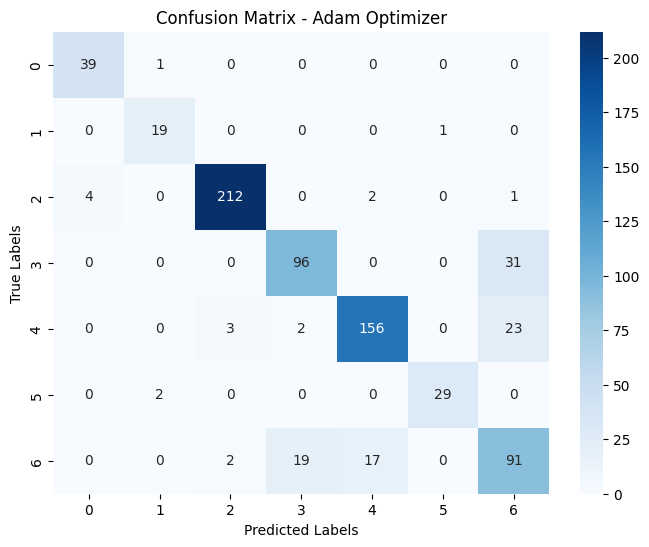

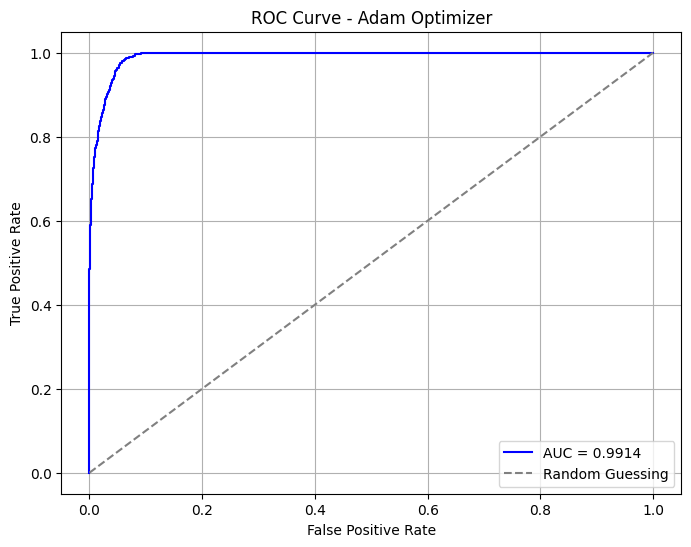

In [9]:
# Defining EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Defining the Adam Optimizer Model
adam_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# Compiling the model
adam_model.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Training, saving, predicting and evaluating the Model
history_adam, y_pred_probs, y_pred_classes, y_true = train_save_evaluate(
    adam_model, "adam_model",
    X_train_resampled, y_train_resampled,
    X_val, y_val, X_test, y_test,
    callbacks=[early_stop]
)

# Computing ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
auc_score = auc(fpr, tpr)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Adam Optimizer")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Adam Optimizer")
plt.legend()
plt.grid(True)
plt.show()

**RMSprop OPTMIZER**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3697 - loss: 1.9341 - val_accuracy: 0.6907 - val_loss: 1.2474
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6123 - loss: 1.1550 - val_accuracy: 0.8427 - val_loss: 0.7480
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6745 - loss: 1.0067 - val_accuracy: 0.8333 - val_loss: 0.6603
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7060 - loss: 0.9274 - val_accuracy: 0.8147 - val_loss: 0.6271
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7249 - loss: 0.8635 - val_accuracy: 0.8373 - val_loss: 0.5869
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7448 - loss: 0.7972 - val_accuracy: 0.8267 - val_loss: 0.5716
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7462 - loss: 0.7837 - val_accuracy: 0.8173 - val_loss: 0.6083
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7525 - loss: 0.7618 - val_accuracy: 0.8040

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

rmsprop_model Results:
 Accuracy: 0.8413
 Precision: 0.8489
 Recall: 0.8413
 F1 Score: 0.8435


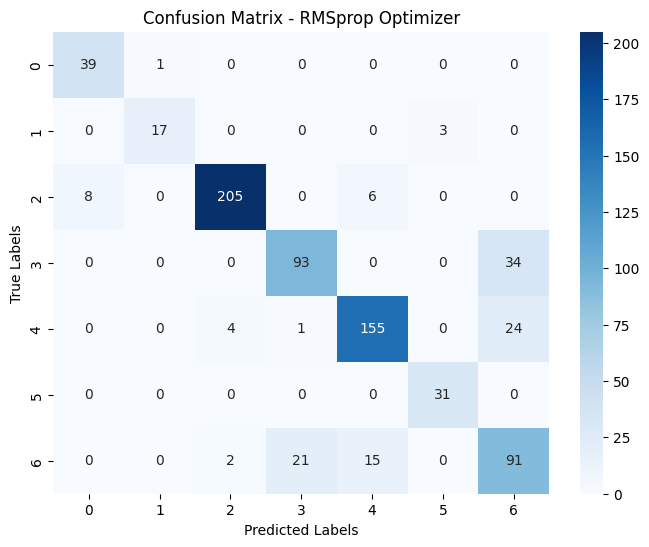

In [10]:
# Defining Neural Network Model with RMSprop Optimizer
rmsprop_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# Compiling the model
rmsprop_model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Training, Saving & Evaluating the model
history_rmsprop, y_pred_probs, y_pred_classes, y_true = train_save_evaluate(
    rmsprop_model, "rmsprop_model", X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test
)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - RMSprop Optimizer")
plt.show()


**SGD + MOMENTUM OPTIMIZER**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3235 - loss: 2.1703 - val_accuracy: 0.5720 - val_loss: 1.5650
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5239 - loss: 1.4184 - val_accuracy: 0.7560 - val_loss: 0.9826
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5814 - loss: 1.2473 - val_accuracy: 0.8133 - val_loss: 0.8197
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6125 - loss: 1.1492 - val_accuracy: 0.8107 - val_loss: 0.7725
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6566 - loss: 1.0665 - val_accuracy: 0.8240 - val_loss: 0.7488
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6577 - loss: 1.0485 - val_accuracy: 0.8333 - val_loss: 0.7164
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6762 - loss: 0.9918 - val_accuracy: 0.8373 - val_loss: 0.7020
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6881 - loss: 0.9770 - val_accuracy: 0.8427

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

sgd_momentum_model Results:
 Accuracy: 0.8747
 Precision: 0.8776
 Recall: 0.8747
 F1 Score: 0.8755


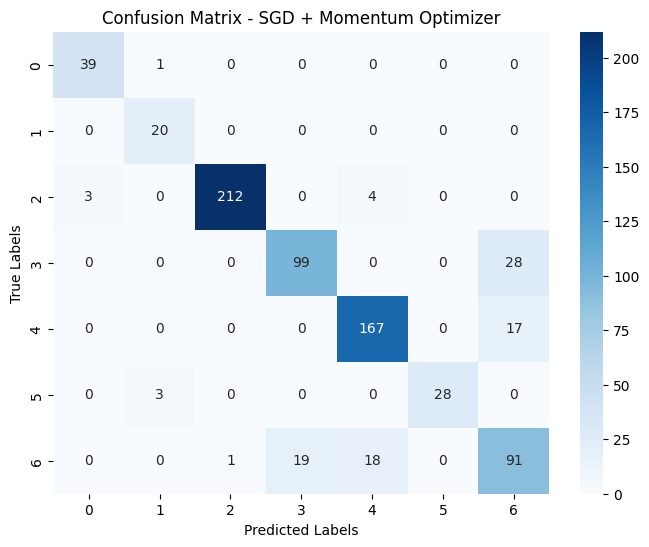

In [11]:
# Define EarlyStopping callback with a patience value of 20 epochs
early_stop_sgd = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Defining the Neural Network Model with SGD + Momentum Optimizer
sgd_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# Compiling the Model
sgd_model.compile(optimizer=SGD(learning_rate=0.0005, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Training, Saving & Evaluating the model with EarlyStopping (patience = 20)
history_sgd, y_pred_probs, y_pred_classes, y_true = train_save_evaluate(
    sgd_model, "sgd_momentum_model",
    X_train_resampled, y_train_resampled,
    X_val, y_val, X_test, y_test,
    callbacks=[early_stop_sgd]
)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SGD + Momentum Optimizer")
plt.show()

**BEST MODEL**

| **Model**                | **Accuracy** | **Precision** | **Recall** | **F1 Score** |
|--------------------------|-------------:|--------------:|-----------:|-------------:|
| **Logistic Regression**  | 0.8240       | 0.8363        | 0.8240     | 0.8273       |
| **RMSprop**              | 0.8413       | 0.8489        | 0.8413     | 0.8435       |
| **Adam**                 | 0.8560       | 0.8615        | 0.8560     | 0.8578       |
| **Simple NN**            | 0.8653       | 0.8644        | 0.8653     | 0.8646       |
| **SGD + Momentum**       | 0.8747       | 0.8776        | 0.8747     | 0.8755       |


Based on the evaluation metrics obtained for each model, SGD + Momentum has the highest accuracy (0.8747) along with strong precision (0.8776), recall (0.8747) and F1 score (0.8755). These results outperform the Simple Neural Network, Adam, RMSprop and Logistic Regression models. Therefor I am proceeding with SGD + Momentum as the best model for final predictions and evaluation.

**EVALUATING & MAKING PREDICTIONS WITH THE BEST MODEL (THE SGD + MOMENTUM)**

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8747
Precision: 0.8776
Recall: 0.8747
F1 Score: 0.8755
ROC AUC: 0.9815
Confusion Matrix:
[[ 39   1   0   0   0   0   0]
 [  0  20   0   0   0   0   0]
 [  3   0 212   0   4   0   0]
 [  0   0   0  99   0   0  28]
 [  0   0   0   0 167   0  17]
 [  0   3   0   0   0  28   0]
 [  0   0   1  19  18   0  91]]


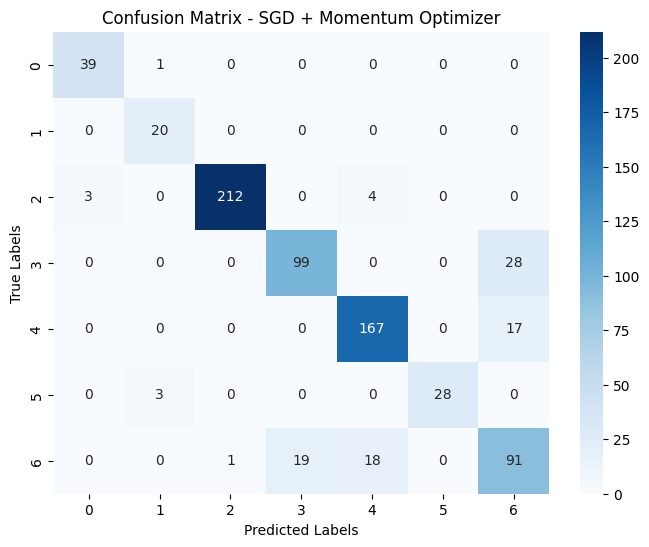

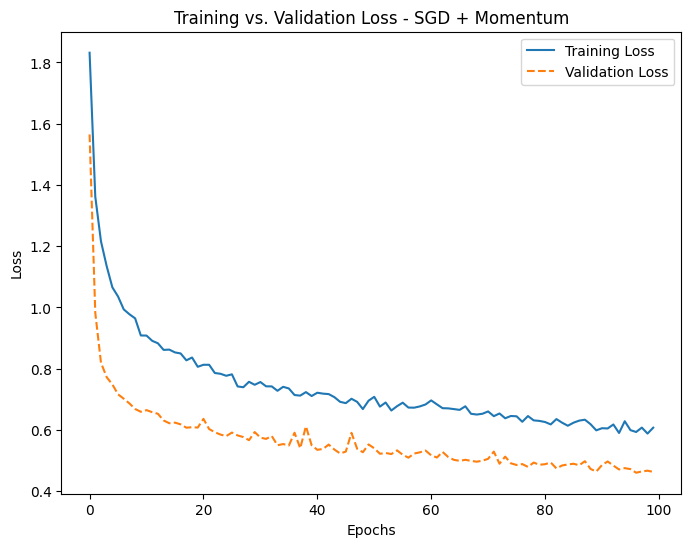

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
best_model_path = "/content/saved_models/sgd_momentum_model.h5"
model = load_model(best_model_path)
pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test, axis=1)

acc = accuracy_score(true_classes, pred_classes)
prec = precision_score(true_classes, pred_classes, average='weighted')
rec = recall_score(true_classes, pred_classes, average='weighted')
f1_val = f1_score(true_classes, pred_classes, average='weighted')
roc_auc = roc_auc_score(y_test, pred_probs, multi_class='ovr', average='weighted')

print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(prec))
print("Recall: {:.4f}".format(rec))
print("F1 Score: {:.4f}".format(f1_val))
print("ROC AUC: {:.4f}".format(roc_auc))

cm_matrix = confusion_matrix(true_classes, pred_classes)
print("Confusion Matrix:")
print(cm_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(true_classes), yticklabels=np.unique(true_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SGD + Momentum Optimizer")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history_sgd.history['loss'], label='Training Loss')
plt.plot(history_sgd.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss - SGD + Momentum")
plt.legend()
plt.show()
